In [68]:
import json
import pandas as pd
import numpy as np
import sys
import random
import os.path
import seaborn as sn
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
sys.path.append('./DnD-Battler/')
import DnD

In [2]:
url = "https://raw.githubusercontent.com/oganm/dnddata/master/data-raw/dnd_chars_all.json"
df = pd.read_json(url)
df = df.transpose()

In [3]:
ignored = ['ip', 'finger', 'date', 'hash', 'choices', 'name', 'country']
dont_process = ['weapons', 'spells', 'skills']
clean_df = pd.json_normalize(df['name'])
clean_df = clean_df['alias'].str[0]

for key in df.keys():
    if key not in ignored:
        if key in dont_process:
            data = df[key].reset_index(drop=True)
        else:
            try: # try doing a json_normalize, which will fail if it's not a json
                data = pd.json_normalize(df[key])
                for col in data.keys(): # unpack the singletons in each json column
                    data[col] = data[col].str[0]
            except AttributeError: 
                data = df[key].str[0]
                data = data.reset_index(drop=True) # use integer index to conform with json_normalize index

        clean_df = pd.concat([clean_df, data], axis=1)

num_spells = df['spells'].apply(len).reset_index(drop=True)
clean_df['num_spells'] = num_spells

# add generic "primary class" column based on highest level class of character
class_list = ['Artificer.level','Barbarian.level','Bard.level','Cleric.level','Druid.level','Fighter.level','Monk.level','Paladin.level','Ranger.level','Rogue.level','Sorcerer.level','Warlock.level','Wizard.level']
class_df = clean_df[class_list]

primary_class = class_df.idxmax(axis=1)
class1 = list(primary_class.str.split('.').str[0])
clean_df['class1'] = class1

# add generic "primary class level" column/label
primary_class_level = class_df.max(axis=1)
clean_df['level1'] = primary_class_level

# one-hot encode castingStat
castingStat = pd.get_dummies(clean_df["castingStat"], prefix='castingStat')
clean_df = pd.concat([clean_df, castingStat], axis = 1)

# one-hot encode processedRace 
processedRace = pd.get_dummies(clean_df["processedRace"], prefix='processedRace')
clean_df = pd.concat([clean_df, processedRace], axis = 1)

# add hp / level
clean_df['hp_per_lvl'] = clean_df['HP'] / clean_df['level1']

In [15]:
level_groups = ['1-3', '4-7', '8-11', '12-15', '16-18', '19-20']
weapon_info = {'club': 4, 'greatclub': 8,
                           'dagger': 4, 'shortsword': 6, 'longsword': 8, 'bastardsword': 10, 'greatsword': 12,
                           'rapier': 8, 'scimitar': 6, 'sickle': 4,
                           'handaxe': 6, 'battleaxe': 8, 'waraxe': 10, 'greataxe': 12,
                           'javelin': 6, 'spear': 6, 'flail': 8, 'glaive': 10, 'halberd': 10, 'lance': 12, 'pike': 10,
                           'trident': 6,
                           'war pick': 8,
                           'lighthammer': 4, 'mace': 6, 'warhammer': 8,
                           'quarterstaff': 6, 'morningstar': 8, 'punch': 1,
                           'whip': 4, 'crossbow, hand': 6}

char_list = {
    '1-3': [],
    '4-7': [], 
    '8-11': [], 
    '12-15': [], 
    '16-18': [], 
    '19-20': []
}

iterations = 500
# clean_df[~clean_df['levelGroup'].isin(levelGroups)]['levelGroup']
#TODO: ignore groups with the exact char combinations as a previous group
for group in level_groups:
    grouped_chars = clean_df[clean_df['levelGroup'] == group]
    
    for n in range(iterations):
#         group_size = random.randint(2, 6)
        group_size = 1

        samples = [grouped_chars.sample(group_size), grouped_chars.sample(group_size)]
        chars = []

        for g in range(len(samples)):
            sample = samples[g]
            group_chars = []

            for i in range(len(sample)):
                char = sample.iloc[i]
                weapons = char['weapons']
                weapon_list = []
                for weapon in weapons:
                    if weapons[weapon]['processedWeapon'][0] is not None:
                        weapon_list.append(weapons[weapon]['processedWeapon'][0].lower())

                best_weapon = 'punch'
                for weapon in weapon_list:
                    if weapon in weapon_info and weapon_info[weapon] > weapon_info[best_weapon]:
                        best_weapon = weapon

                group_chars.append(DnD.Creature(f'group_{g}_{i}', abilities={'dex': char['Dex'], 'str': char['Str'], 'cha': char['Cha'], 'con': char['Con'], 
                                              'int': char['Int'], 'wis': char['Wis']}, 
                         ac=char.AC, hp=char.HP, attack_parameters=best_weapon, level=char['level'], alignment=f'group{g}' ))

            chars.append(group_chars)

        char_list[group].append(chars)


19 1 3
choice HD... 4.0
18 3 2
choice HD... 4.0
12 2 1
choice HD... 5.0
24 2 3
choice HD... 4.5
13 3 1
choice HD... 5.0
15 3 1
choice HD... 6.0
11 3 2
choice HD... 1.6666666666666667
8 0 1
choice HD... 4.0
44 4 3
choice HD... 8.0
12 1 2
choice HD... 3.3333333333333335
24 0 3
choice HD... 6.0
39 4 3
choice HD... 6.75
12 2 1
choice HD... 5.0
26 1 3
choice HD... 5.75
6 0 1
choice HD... 3.0
11 2 1
choice HD... 4.5
5 0 1
choice HD... 2.5
7 1 1
choice HD... 3.0
9 -1 1
choice HD... 5.0
8 2 1
choice HD... 3.0
14 2 2
choice HD... 3.3333333333333335
24 2 3
choice HD... 4.5
11 3 1
choice HD... 4.0
13 -1 3
choice HD... 4.0
9 1 1
choice HD... 4.0
26 4 3
choice HD... 3.5
8 2 1
choice HD... 3.0
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
7 -1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
37 2 3
choice HD... 7.75
21 1 3
choice HD... 4.5
8 0 1
choice HD... 4.0
11 3 1
choice HD... 4.0
8 2 1
choice HD... 3.0
11 3 1
choice HD... 4.0
9 1 1
choice HD... 4.0
11 3 1
choice HD... 4.0
12

./DnD-Battler/DnD.py:383: UserWarning: Unfinished case to guess HD. so Defaulting hit dice to d8 instead
  warnings.warn('Unfinished case to guess HD. so Defaulting hit dice to d8 instead')  # TODO finish


9 1 1
choice HD... 4.0
12 2 1
choice HD... 5.0
28 2 3
choice HD... 5.5
15 1 2
choice HD... 4.333333333333333
13 3 1
choice HD... 5.0
9 -1 1
choice HD... 5.0
11 3 1
choice HD... 4.0
24 1 3
choice HD... 5.25
12 2 2
choice HD... 2.6666666666666665
7 -1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
23 2 3
choice HD... 4.25
10 2 1
choice HD... 4.0
45 2 1
choice HD... 21.5
10 2 1
choice HD... 4.0
23 3 2
choice HD... 5.666666666666667
30 2 3
choice HD... 6.0
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
8 0 1
choice HD... 4.0
17 2 2
choice HD... 4.333333333333333
15 2 3
choice HD... 2.25
8 0 1
choice HD... 4.0
10 2 1
choice HD... 4.0
11 1 1
choice HD... 5.0
27 2 3
choice HD... 5.25
16 2 2
choice HD... 4.0
11 3 1
choice HD... 4.0
28 2 3
choice HD... 5.5
10 2 1
choice HD... 4.0
21 2 2
choice HD... 5.666666666666667
22 3 2
choice HD... 5.333333333333333
6 -1 1
choice HD... 3.5
6 0 1
choice HD... 3.0
28 2 3
choice HD... 5.5
9 1 1
choice HD... 4.0
30 3 3
choice HD... 5.25
10 2 1
choice HD... 4.0
11 

24 2 3
choice HD... 4.5
12 2 1
choice HD... 5.0
16 0 2
choice HD... 5.333333333333333
18 1 3
choice HD... 3.75
30 3 3
choice HD... 5.25
9 3 1
choice HD... 3.0
11 1 1
choice HD... 5.0
35 3 3
choice HD... 6.5
8 0 1
choice HD... 4.0
10 2 1
choice HD... 4.0
14 1 2
choice HD... 4.0
10 2 1
choice HD... 4.0
28 2 2
choice HD... 8.0
15 3 1
choice HD... 6.0
11 3 1
choice HD... 4.0
21 0 3
choice HD... 5.25
9 2 1
choice HD... 3.5
27 3 3
choice HD... 4.5
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
31 4 2
choice HD... 7.666666666666667
17 2 2
choice HD... 4.333333333333333
24 2 3
choice HD... 4.5
13 3 1
choice HD... 5.0
33 5 3
choice HD... 4.5
15 1 2
choice HD... 4.333333333333333
11 1 1
choice HD... 5.0
22 -2 3
choice HD... 7.0
30 2 3
choice HD... 6.0
22 3 2
choice HD... 5.333333333333333
24 1 3
choice HD... 5.25
28 2 3
choice HD... 5.5
10 2 1
choice HD... 4.0
8 0 1
choice HD... 4.0
8 0 1
choice HD... 4.0
18 1 2
choice HD... 5.333333333333333
10 2 1
choice HD... 4.0
12 4 1
choice HD... 4.0
9 1 1

6 1 2
choice HD... 1.3333333333333333
12 2 1
choice HD... 5.0
21 2 2
choice HD... 5.666666666666667
12 4 1
choice HD... 4.0
19 2 2
choice HD... 5.0
24 2 3
choice HD... 4.5
10 2 1
choice HD... 4.0
25 3 3
choice HD... 4.0
12 1 3
choice HD... 2.25
25 3 2
choice HD... 6.333333333333333
15 1 2
choice HD... 4.333333333333333
8 0 1
choice HD... 4.0
8 0 1
choice HD... 4.0
24 2 3
choice HD... 4.5
31 3 3
choice HD... 5.5
28 3 3
choice HD... 4.75
12 2 1
choice HD... 5.0
24 1 3
choice HD... 5.25
22 3 2
choice HD... 5.333333333333333
13 0 2
choice HD... 4.333333333333333
29 2 3
choice HD... 5.75
24 2 3
choice HD... 4.5
31 3 3
choice HD... 5.5
20 2 3
choice HD... 3.5
36 2 3
choice HD... 7.5
24 4 2
choice HD... 5.333333333333333
18 0 3
choice HD... 4.5
10 2 1
choice HD... 4.0
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
18 0 3
choice HD... 4.5
28 2 3
choice HD... 5.5
11 1 1
choice HD... 5.0
29 1 3
choice HD... 6.5
11 2 1
choice HD... 4.5
20 1 2
choice HD... 6.0
10 2 1
choice HD... 4.0
14 4 1
choice

63 3 5
choice HD... 8.0
31 2 4
choice HD... 4.6
43 1 6
choice HD... 5.285714285714286
44 2 4
choice HD... 7.2
33 1 4
choice HD... 5.8
48 2 6
choice HD... 5.142857142857143
67 2 7
choice HD... 6.625
43 2 6
choice HD... 4.428571428571429
59 3 7
choice HD... 4.75
52 3 5
choice HD... 6.166666666666667
31 2 4
choice HD... 4.6
38 2 5
choice HD... 4.666666666666667
35 1 4
choice HD... 6.2
44 2 7
choice HD... 3.75
45 1 5
choice HD... 6.666666666666667
60 2 5
choice HD... 8.333333333333334
32 1 4
choice HD... 5.6
30 3 4
choice HD... 3.6
28 2 4
choice HD... 4.0
48 2 4
choice HD... 8.0
38 0 7
choice HD... 4.75
87 5 6
choice HD... 8.142857142857142
46 3 4
choice HD... 6.8
68 2 7
choice HD... 6.75
52 2 7
choice HD... 4.75
50 2 7
choice HD... 4.5
50 2 5
choice HD... 6.666666666666667
47 4 4
choice HD... 6.2
47 1 7
choice HD... 5.0
48 2 4
choice HD... 8.0
40 2 5
choice HD... 5.0
31 2 4
choice HD... 4.6
41 2 4
choice HD... 6.6
30 1 4
choice HD... 5.2
28 0 5
choice HD... 4.666666666666667
30 0 5
choice

82 4 7
choice HD... 6.75
31 2 4
choice HD... 4.6
36 2 4
choice HD... 5.6
80 3 7
choice HD... 7.375
50 2 6
choice HD... 5.428571428571429
32 1 4
choice HD... 5.6
47 2 6
choice HD... 5.0
35 2 4
choice HD... 5.4
33 0 6
choice HD... 4.714285714285714
31 2 4
choice HD... 4.6
38 1 4
choice HD... 6.8
32 2 4
choice HD... 4.8
38 1 5
choice HD... 5.5
60 2 5
choice HD... 8.333333333333334
45 2 5
choice HD... 5.833333333333333
56 3 5
choice HD... 6.833333333333333
33 1 5
choice HD... 4.666666666666667
52 2 6
choice HD... 5.714285714285714
24 2 5
choice HD... 2.3333333333333335
42 1 6
choice HD... 5.142857142857143
41 2 5
choice HD... 5.166666666666667
43 3 5
choice HD... 4.666666666666667
44 3 4
choice HD... 6.4
36 1 6
choice HD... 4.285714285714286
33 2 5
choice HD... 3.8333333333333335
44 2 4
choice HD... 7.2
22 1 4
choice HD... 3.6
39 1 5
choice HD... 5.666666666666667
35 1 5
choice HD... 5.0
40 2 4
choice HD... 6.4
48 2 5
choice HD... 6.333333333333333
32 1 4
choice HD... 5.6
34 2 4
choice HD.

20 0 5
choice HD... 3.3333333333333335
31 2 5
choice HD... 3.5
35 2 6
choice HD... 3.2857142857142856
49 3 5
choice HD... 5.666666666666667
43 2 6
choice HD... 4.428571428571429
48 3 5
choice HD... 5.5
44 2 5
choice HD... 5.666666666666667
28 3 7
choice HD... 0.875
70 4 5
choice HD... 8.333333333333334
57 2 7
choice HD... 5.375
56 3 5
choice HD... 6.833333333333333
44 2 5
choice HD... 5.666666666666667
26 2 4
choice HD... 3.6
60 4 5
choice HD... 6.666666666666667
41 2 5
choice HD... 5.166666666666667
52 2 7
choice HD... 4.75
23 1 4
choice HD... 3.8
21 2 5
choice HD... 1.8333333333333333
53 2 5
choice HD... 7.166666666666667
50 2 6
choice HD... 5.428571428571429
30 1 5
choice HD... 4.166666666666667
71 1 7
choice HD... 8.0
34 0 5
choice HD... 5.666666666666667
64 4 6
choice HD... 5.714285714285714
45 2 5
choice HD... 5.833333333333333
30 1 4
choice HD... 5.2
49 2 7
choice HD... 4.375
44 2 4
choice HD... 7.2
44 2 5
choice HD... 5.666666666666667
29 1 5
choice HD... 4.0
64 2 6
choice HD..

73 2 10
choice HD... 4.818181818181818
50 0 8
choice HD... 5.555555555555555
104 2 10
choice HD... 7.636363636363637
100 4 10
choice HD... 5.454545454545454
77 3 9
choice HD... 5.0
62 2 10
choice HD... 3.8181818181818183
71 3 8
choice HD... 5.222222222222222
59 2 8
choice HD... 4.777777777777778
62 2 8
choice HD... 5.111111111111111
66 2 9
choice HD... 4.8
83 3 9
choice HD... 5.6
53 0 10
choice HD... 4.818181818181818
35 -1 8
choice HD... 4.777777777777778
75 3 8
choice HD... 5.666666666666667
47 0 8
choice HD... 5.222222222222222
101 5 8
choice HD... 6.777777777777778
74 1 10
choice HD... 5.818181818181818
74 2 8
choice HD... 6.444444444444445
71 3 8
choice HD... 5.222222222222222
69 2 8
choice HD... 5.888888888888889
64 2 8
choice HD... 5.333333333333333
160 4 10
choice HD... 10.909090909090908
90 3 10
choice HD... 5.454545454545454
87 2 8
choice HD... 7.888888888888889
66 2 10
choice HD... 4.181818181818182
69 4 8
choice HD... 4.111111111111111
80 0 10
choice HD... 7.272727272727272

138 4 9
choice HD... 10.2
88 2 10
choice HD... 6.181818181818182
109 3 9
choice HD... 8.2
59 2 8
choice HD... 4.777777777777778
49 3 8
choice HD... 2.7777777777777777
85 3 9
choice HD... 5.8
65 3 8
choice HD... 4.555555555555555
108 3 8
choice HD... 9.333333333333334
51 1 8
choice HD... 4.777777777777778
92 1 10
choice HD... 7.454545454545454
50 0 8
choice HD... 5.555555555555555
35 3 9
choice HD... 0.8
66 2 9
choice HD... 4.8
66 4 8
choice HD... 3.7777777777777777
95 3 9
choice HD... 6.8
95 1 11
choice HD... 7.0
96 4 10
choice HD... 5.090909090909091
92 1 10
choice HD... 7.454545454545454
75 3 8
choice HD... 5.666666666666667
51 1 8
choice HD... 4.777777777777778
75 3 8
choice HD... 5.666666666666667
68 1 9
choice HD... 5.9
94 3 10
choice HD... 5.818181818181818
86 3 10
choice HD... 5.090909090909091
139 3 11
choice HD... 8.833333333333334
104 4 10
choice HD... 5.818181818181818
140 4 10
choice HD... 9.090909090909092
51 1 8
choice HD... 4.777777777777778
99 3 9
choice HD... 7.2
122 2

choice HD... 5.6
83 3 9
choice HD... 5.6
59 2 8
choice HD... 4.777777777777778
72 1 10
choice HD... 5.636363636363637
63 1 10
choice HD... 4.818181818181818
71 2 8
choice HD... 6.111111111111111
73 4 8
choice HD... 4.555555555555555
72 1 9
choice HD... 6.3
84 2 10
choice HD... 5.818181818181818
77 3 9
choice HD... 5.0
80 2 10
choice HD... 5.454545454545454
102 4 10
choice HD... 5.636363636363637
99 3 9
choice HD... 7.2
54 2 9
choice HD... 3.6
51 1 8
choice HD... 4.777777777777778
78 5 8
choice HD... 4.222222222222222
59 2 8
choice HD... 4.777777777777778
66 2 9
choice HD... 4.8
86 2 10
choice HD... 6.0
83 3 10
choice HD... 4.818181818181818
80 2 11
choice HD... 4.833333333333333
61 2 8
choice HD... 5.0
72 1 9
choice HD... 6.3
72 3 9
choice HD... 4.5
96 3 8
choice HD... 8.0
83 3 10
choice HD... 4.818181818181818
100 3 8
choice HD... 8.444444444444445
59 2 8
choice HD... 4.777777777777778
68 2 8
choice HD... 5.777777777777778
48 0 9
choice HD... 4.8
34 0 8
choice HD... 3.7777777777777777

82 2 13
choice HD... 4.0
112 3 13
choice HD... 5.214285714285714
108 3 15
choice HD... 3.9375
181 3 15
choice HD... 8.5
107 1 15
choice HD... 5.75
141 5 12
choice HD... 6.230769230769231
100 2 12
choice HD... 5.846153846153846
149 5 12
choice HD... 6.846153846153846
192 4 12
choice HD... 11.076923076923077
140 2 14
choice HD... 7.466666666666667
149 4 12
choice HD... 7.769230769230769
106 2 12
choice HD... 6.3076923076923075
225 5 15
choice HD... 9.375
154 3 14
choice HD... 7.466666666666667
111 4 12
choice HD... 4.846153846153846
137 4 12
choice HD... 6.846153846153846
118 3 13
choice HD... 5.642857142857143
78 1 12
choice HD... 5.076923076923077
86 3 12
choice HD... 3.8461538461538463
159 2 15
choice HD... 8.0625
87 1 13
choice HD... 5.285714285714286
100 2 12
choice HD... 5.846153846153846
184 2 15
choice HD... 9.625
107 3 13
choice HD... 4.857142857142857
104 1 15
choice HD... 5.5625
108 2 13
choice HD... 5.857142857142857
162 5 12
choice HD... 7.846153846153846
131 3 12
choice HD.

137 4 15
choice HD... 4.8125
132 3 12
choice HD... 7.384615384615385
72 1 13
choice HD... 4.214285714285714
153 5 15
choice HD... 4.875
137 4 13
choice HD... 6.071428571428571
144 2 12
choice HD... 9.23076923076923
116 3 12
choice HD... 6.153846153846154
142 3 14
choice HD... 6.666666666666667
95 2 13
choice HD... 4.928571428571429
143 3 14
choice HD... 6.733333333333333
168 4 14
choice HD... 7.466666666666667
201 4 15
choice HD... 8.8125
150 4 12
choice HD... 7.846153846153846
232 4 15
choice HD... 10.75
131 2 12
choice HD... 8.23076923076923
132 5 15
choice HD... 3.5625
196 5 12
choice HD... 10.461538461538462
138 4 15
choice HD... 4.875
84 2 12
choice HD... 4.615384615384615
74 2 12
choice HD... 3.8461538461538463
139 2 15
choice HD... 6.8125
122 2 15
choice HD... 5.75
69 1 13
choice HD... 4.0
144 3 13
choice HD... 7.5
106 1 15
choice HD... 5.6875
99 3 12
choice HD... 4.846153846153846
133 3 12
choice HD... 7.461538461538462
116 3 12
choice HD... 6.153846153846154
72 1 13
choice HD.

201 4 15
choice HD... 8.8125
119 3 12
choice HD... 6.384615384615385
142 3 14
choice HD... 6.666666666666667
99 1 12
choice HD... 6.6923076923076925
144 2 12
choice HD... 9.23076923076923
180 4 15
choice HD... 7.5
196 3 14
choice HD... 10.266666666666667
182 2 14
choice HD... 10.266666666666667
124 4 12
choice HD... 5.846153846153846
122 2 15
choice HD... 5.75
108 1 12
choice HD... 7.384615384615385
153 5 15
choice HD... 4.875
143 3 14
choice HD... 6.733333333333333
163 3 15
choice HD... 7.375
139 4 12
choice HD... 7.0
201 4 15
choice HD... 8.8125
149 4 15
choice HD... 5.5625
112 3 12
choice HD... 5.846153846153846
144 2 12
choice HD... 9.23076923076923
92 2 14
choice HD... 4.266666666666667
112 3 12
choice HD... 5.846153846153846
107 3 12
choice HD... 5.461538461538462
108 3 12
choice HD... 5.538461538461538
77 2 12
choice HD... 4.076923076923077
137 4 12
choice HD... 6.846153846153846
123 3 15
choice HD... 4.875
143 1 15
choice HD... 8.0
158 3 14
choice HD... 7.733333333333333
100 2 

252 5 18
choice HD... 8.526315789473685
208 3 16
choice HD... 9.411764705882353
104 2 16
choice HD... 4.235294117647059
182 5 16
choice HD... 6.0
115 2 16
choice HD... 4.882352941176471
160 4 16
choice HD... 5.647058823529412
182 4 18
choice HD... 5.7894736842105265
232 5 18
choice HD... 7.473684210526316
129 2 18
choice HD... 4.894736842105263
125 3 17
choice HD... 4.111111111111111
125 2 17
choice HD... 5.055555555555555
194 3 16
choice HD... 8.588235294117647
178 4 17
choice HD... 6.111111111111111
191 5 17
choice HD... 5.888888888888889
232 5 18
choice HD... 7.473684210526316
232 5 18
choice HD... 7.473684210526316
111 2 16
choice HD... 4.647058823529412
232 5 18
choice HD... 7.473684210526316
124 1 16
choice HD... 6.352941176470588
114 2 18
choice HD... 4.105263157894737
183 4 17
choice HD... 6.388888888888889
194 3 16
choice HD... 8.588235294117647
176 1 16
choice HD... 9.411764705882353
134 3 16
choice HD... 5.0588235294117645
172 5 16
choice HD... 5.411764705882353
202 3 18
cho

191 6 16
choice HD... 5.588235294117647
150 2 16
choice HD... 6.9411764705882355
130 2 16
choice HD... 5.764705882352941
107 1 16
choice HD... 5.352941176470588
198 3 16
choice HD... 8.823529411764707
20 0 18
choice HD... 1.0526315789473684
139 1 17
choice HD... 6.777777777777778
116 1 16
choice HD... 5.882352941176471
232 5 18
choice HD... 7.473684210526316
160 2 16
choice HD... 7.529411764705882
225 5 17
choice HD... 7.777777777777778
144 3 16
choice HD... 5.647058823529412
194 3 16
choice HD... 8.588235294117647
176 3 16
choice HD... 7.529411764705882
89 1 17
choice HD... 4.0
176 1 16
choice HD... 9.411764705882353
104 2 16
choice HD... 4.235294117647059
139 1 17
choice HD... 6.777777777777778
202 3 18
choice HD... 7.7894736842105265
134 3 16
choice HD... 5.0588235294117645
20 0 18
choice HD... 1.0526315789473684
118 2 16
choice HD... 5.0588235294117645
121 2 16
choice HD... 5.235294117647059
117 3 16
choice HD... 4.0588235294117645
136 3 17
choice HD... 4.722222222222222
117 3 16
c

125 3 17
choice HD... 4.111111111111111
182 5 16
choice HD... 6.0
202 3 18
choice HD... 7.7894736842105265
206 3 17
choice HD... 8.61111111111111
302 5 16
choice HD... 13.058823529411764
182 4 18
choice HD... 5.7894736842105265
87 1 17
choice HD... 3.888888888888889
130 2 16
choice HD... 5.764705882352941
252 5 18
choice HD... 8.526315789473685
198 3 16
choice HD... 8.823529411764707
87 1 17
choice HD... 3.888888888888889
216 5 17
choice HD... 7.277777777777778
149 4 17
choice HD... 4.5
167 3 16
choice HD... 7.0
302 5 16
choice HD... 13.058823529411764
168 4 16
choice HD... 6.117647058823529
216 5 16
choice HD... 8.0
224 4 16
choice HD... 9.411764705882353
129 2 18
choice HD... 4.894736842105263
160 2 16
choice HD... 7.529411764705882
146 4 18
choice HD... 3.8947368421052633
183 4 17
choice HD... 6.388888888888889
194 6 16
choice HD... 5.764705882352941
150 2 16
choice HD... 6.9411764705882355
150 2 16
choice HD... 6.9411764705882355
150 2 16
choice HD... 6.9411764705882355
229 4 16
ch

148 3 16
choice HD... 5.882352941176471
150 3 18
choice HD... 5.052631578947368
176 1 16
choice HD... 9.411764705882353
145 3 16
choice HD... 5.705882352941177
182 4 18
choice HD... 5.7894736842105265
195 3 18
choice HD... 7.421052631578948
102 2 16
choice HD... 4.117647058823529
150 3 18
choice HD... 5.052631578947368
146 4 18
choice HD... 3.8947368421052633
216 5 17
choice HD... 7.277777777777778
164 4 16
choice HD... 5.882352941176471
167 3 16
choice HD... 7.0
217 4 18
choice HD... 7.631578947368421
105 -1 18
choice HD... 6.473684210526316
164 4 16
choice HD... 5.882352941176471
198 3 17
choice HD... 8.166666666666666
198 3 17
choice HD... 8.166666666666666
89 1 17
choice HD... 4.0
176 2 17
choice HD... 7.888888888888889
102 2 16
choice HD... 4.117647058823529
174 4 17
choice HD... 5.888888888888889
117 3 16
choice HD... 4.0588235294117645
176 3 16
choice HD... 7.529411764705882
194 3 16
choice HD... 8.588235294117647
208 3 16
choice HD... 9.411764705882353
155 3 16
choice HD... 6.2

129 2 18
choice HD... 4.894736842105263
129 2 18
choice HD... 4.894736842105263
105 0 16
choice HD... 6.176470588235294
117 3 16
choice HD... 4.0588235294117645
130 2 16
choice HD... 5.764705882352941
160 2 16
choice HD... 7.529411764705882
198 3 17
choice HD... 8.166666666666666
229 4 16
choice HD... 9.705882352941176
116 1 16
choice HD... 5.882352941176471
160 3 16
choice HD... 6.588235294117647
168 4 16
choice HD... 6.117647058823529
170 3 18
choice HD... 6.105263157894737
110 1 16
choice HD... 5.529411764705882
191 6 16
choice HD... 5.588235294117647
195 3 18
choice HD... 7.421052631578948
216 4 18
choice HD... 7.578947368421052
198 3 17
choice HD... 8.166666666666666
216 5 17
choice HD... 7.277777777777778
114 2 18
choice HD... 4.105263157894737
20 0 18
choice HD... 1.0526315789473684
149 4 17
choice HD... 4.5
118 2 16
choice HD... 5.0588235294117645
120 1 20
choice HD... 4.761904761904762
124 0 20
choice HD... 5.904761904761905
280 2 20
choice HD... 11.428571428571429
10 1 20
cho

182 4 20
choice HD... 4.857142857142857
163 3 20
choice HD... 4.904761904761905
285 4 20
choice HD... 9.761904761904763
245 5 20
choice HD... 6.904761904761905
163 3 20
choice HD... 4.904761904761905
143 2 20
choice HD... 4.904761904761905
143 2 20
choice HD... 4.904761904761905
200 2 20
choice HD... 7.619047619047619
133 1 20
choice HD... 5.380952380952381
195 4 20
choice HD... 5.476190476190476
123 1 20
choice HD... 4.904761904761905
240 2 20
choice HD... 9.523809523809524
163 3 20
choice HD... 4.904761904761905
359 5 20
choice HD... 12.333333333333334
163 3 20
choice HD... 4.904761904761905
160 0 20
choice HD... 7.619047619047619
189 4 20
choice HD... 5.190476190476191
125 1 20
choice HD... 5.0
212 3 20
choice HD... 7.238095238095238
103 0 20
choice HD... 4.904761904761905
123 1 20
choice HD... 4.904761904761905
300 3 20
choice HD... 11.428571428571429
103 0 20
choice HD... 4.904761904761905
133 1 20
choice HD... 5.380952380952381
300 3 20
choice HD... 11.428571428571429
150 1 20
ch

143 2 20
choice HD... 4.904761904761905
175 1 19
choice HD... 7.8
260 5 20
choice HD... 7.619047619047619
200 2 20
choice HD... 7.619047619047619
156 2 20
choice HD... 5.523809523809524
245 5 20
choice HD... 6.904761904761905
155 2 20
choice HD... 5.476190476190476
248 2 20
choice HD... 9.904761904761905
218 4 20
choice HD... 6.571428571428571
301 7 20
choice HD... 7.666666666666667
182 5 20
choice HD... 3.9047619047619047
274 7 20
choice HD... 6.380952380952381
243 7 20
choice HD... 4.904761904761905
240 4 20
choice HD... 7.619047619047619
120 1 20
choice HD... 4.761904761904762
163 2 20
choice HD... 5.857142857142857
143 2 20
choice HD... 4.904761904761905
285 4 20
choice HD... 9.761904761904763
144 2 20
choice HD... 4.9523809523809526
156 2 20
choice HD... 5.523809523809524
271 5 20
choice HD... 8.142857142857142
195 4 20
choice HD... 5.476190476190476
103 0 20
choice HD... 4.904761904761905
225 3 20
choice HD... 7.857142857142857
183 3 20
choice HD... 5.857142857142857
200 2 20
cho

224 3 20
choice HD... 7.809523809523809
103 0 20
choice HD... 4.904761904761905
183 2 20
choice HD... 6.809523809523809
359 6 20
choice HD... 11.380952380952381
143 2 20
choice HD... 4.904761904761905
124 0 20
choice HD... 5.904761904761905
92 2 20
choice HD... 2.4761904761904763
121 1 20
choice HD... 4.809523809523809
301 7 20
choice HD... 7.666666666666667
224 5 20
choice HD... 5.904761904761905
144 2 20
choice HD... 4.9523809523809526
209 3 20
choice HD... 7.095238095238095
240 4 20
choice HD... 7.619047619047619
167 4 20
choice HD... 4.142857142857143
103 0 20
choice HD... 4.904761904761905
138 3 20
choice HD... 3.7142857142857144
124 0 20
choice HD... 5.904761904761905
225 3 20
choice HD... 7.857142857142857
166 3 20
choice HD... 5.0476190476190474
202 4 20
choice HD... 5.809523809523809
295 5 20
choice HD... 9.285714285714286
163 3 20
choice HD... 4.904761904761905
143 2 20
choice HD... 4.904761904761905
203 5 20
choice HD... 4.904761904761905
284 5 20
choice HD... 8.761904761904

In [58]:
def calc_avg_roll(die):
    split_die = die.split('d')
    die_nums = split_die[1].split('+')
    if split_die[0] == '':
        num_die = 1
    else: 
        num_die = int(split_die[0])
        
    max_roll = int(die_nums[0])
    if len(die_nums) == 1:
        modifier = 0
    else: 
        modifier = int(die_nums[1])
    
    
    
    return  (((max_roll + 1 ) / 2 ) + modifier) * num_die

# Scales a matrix either using given parameters, or if none scales it to be standard normal.
# TODO: what to do if std is 0??
def scale_matrix(X, mean=None, var=None):
    if mean is None:
        mean = np.mean(X, axis=0)
    
    if var is None:
        var = np.var(X, axis=0)
        
    std = np.sqrt(var)
        
    for i in range(len(X)):
        for j in range(len(X[0])):
            if std[j] == 0:
                std[j] = 1
            X[i][j] = (X[i][j] - mean[j]) / std[j]
    
    return X, mean, var

def k_fold_validation(X, y, C, gamma, k, model_type = 'classification'):
    accuracy = defaultdict()
    for c in C:
        for g in gamma:
            tmp = list(zip(X, y))
            random.shuffle(tmp)
            X_shfl, y_shfl = zip(*tmp) 
            X_spl = np.array_split(X_shfl, k)
            y_spl = np.array_split(y_shfl, k)
            
            for i in range(len(X_spl)):
                X_train = [item for li in X_spl[:i] for item in li] + [item for li in X_spl[i + 1:] for item in li]
                X_validate = X_spl[i]
                
                y_train = [item for li in y_spl[:i] for item in li] + [item for li in y_spl[i + 1:] for item in li]
                y_validate = y_spl[i]
                
                if model_type == 'classification':
                    svm = SVC(C=c, gamma=g)
                elif model_type == 'regression':
                    svm = SVR(C=c, gamma=g)
                else:
                    raise Exception('model_type must be classification or regression') 
                svm.fit(X_train, y_train)
                accuracy[(c, g)] = svm.score(X_validate, y_validate)
            
    return accuracy

In [16]:
simulation_file_path = './simulations.csv'
number_simulations = 1000
if os.path.isfile(simulation_file_path):
    df = pd.read_csv(simulation_file_path)
else:
    df = pd.DataFrame(columns=['level', 'proficiency', 'able', 'strength', 
                               'con', 'wis', 'intelligence', 'cha', 'hd', 'hp', 'ac', 'initiative', 'healing_spells',
                               'buff_spells', 'attack_bonus', 'weapon_damage', 'winrate'])

for level_group in level_groups:
    for chars in char_list[level_group]:
        # Currently hardcoded for 1 char / group, 2 groups
        arena = DnD.Encounter(*chars[0], *chars[1])
        res = json.loads(arena.go_to_war(number_simulations).json())
        
        
        battle_results = {
            res['team_names'][0]: {
                'victories': res['team_victories'][0],
                'close': res['team_close'][0],
            },

            res['team_names'][1]: {
                'victories': res['team_victories'][1],
                'close': res['team_close'][1]
            }
        }

        battle_results[chars[0][0].__dict__['alignment']]['chars'] = [c.__dict__ for c in chars[0]]
        battle_results[chars[1][0].__dict__['alignment']]['chars'] = [c.__dict__ for c in chars[1]]
        
        group0_char_dict = battle_results['group0']['chars'][0]
        group0_char_info = {
            'level': group0_char_dict['level'],
            'proficiency': group0_char_dict['proficiency'],
            'able': group0_char_dict['able'],
            'strength': group0_char_dict['abilities']['str'],
            'con': group0_char_dict['abilities']['con'],
            'wis': group0_char_dict['abilities']['wis'],
            'intelligence': group0_char_dict['abilities']['int'],
            'cha': group0_char_dict['abilities']['cha'],
            'hd': calc_avg_roll(str(group0_char_dict['hd'])),
            'hp': group0_char_dict['hp'],
            'ac': group0_char_dict['ac'],
            'initiative': calc_avg_roll(str(group0_char_dict['initiative'])),
            'healing_spells': group0_char_dict['healing_spells'],
            'buff_spells': group0_char_dict['buff_spells'],
            'attack_bonus': group0_char_dict['attack_parameters'][0][2],
            'weapon_damage': group0_char_dict['attack_parameters'][0][3]
        }
        
        group1_char_dict = battle_results['group1']['chars'][0]
        group1_char_info = {
            'level': group1_char_dict['level'],
            'proficiency': group1_char_dict['proficiency'],
            'able': group1_char_dict['able'],
            'strength': group1_char_dict['abilities']['str'],
            'con': group1_char_dict['abilities']['con'],
            'wis': group1_char_dict['abilities']['wis'],
            'intelligence': group1_char_dict['abilities']['int'],
            'cha': group1_char_dict['abilities']['cha'],
            'hd': calc_avg_roll(str(group1_char_dict['hd'])),
            'hp': group1_char_dict['hp'],
            'ac': group1_char_dict['ac'],
            'initiative': calc_avg_roll(str(group1_char_dict['initiative'])),
            'healing_spells': group1_char_dict['healing_spells'],
            'buff_spells': group1_char_dict['buff_spells'],
            'attack_bonus': group1_char_dict['attack_parameters'][0][2],
            'weapon_damage': group1_char_dict['attack_parameters'][0][3]
        }

        diff = {}
        # TODO: potentially exclude outliers if hp/damage/other attributes are too imbalanced
        for key in group0_char_info.keys():
            if type(group0_char_info[key]) is list:
                diff[key] = [group0_char_info[key][i] - group1_char_info[key][i] for i in range(len(group0_char_info[key]))]
            else:
                diff[key] = group0_char_info[key] - group1_char_info[key]
        
    
        diff['winrate'] = battle_results['group0']['victories'] / number_simulations
        
        df = df.append(diff, ignore_index=True)

df.to_csv(simulation_file_path, index = False)
print(df)
    
# Attack params are attack bonus, weapon damage

# for key in test['group1']['chars'][0].__dict__.keys():
#     print(key + ": " + str(test['group1']['chars'][0].__dict__[key]) + "\n")


# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(clean_df.iloc[0])
    
# weapons = clean_df.iloc[0]['weapons']
# for weapon in weapons:
#     print(weapons[weapon]['processedWeapon'])
    
# clean_df
# pd.json_normalize(clean_df.iloc[0]['weapons'])

      level  proficiency  able  strength  con  wis  intelligence  cha   hd  \
0       1.0          1.0   0.0      -5.0 -4.0 -1.0           7.0  6.0 -2.0   
1      -2.0         -1.0   0.0       8.0  0.0 -3.0           0.0  0.0  0.0   
2       0.0          0.0   0.0      -1.0 -1.0  0.0           0.0  3.0  0.0   
3       1.0          0.0   0.0       8.0  6.0  1.0          -4.0 -2.0  3.0   
4       1.0          1.0   0.0       4.0  7.0 -8.0           2.0 -2.0  3.0   
...     ...          ...   ...       ...  ...  ...           ...  ...  ...   
2995    1.0          0.0   0.0      -3.0  2.0 -4.0           0.0 -5.0  1.0   
2996    0.0          0.0   0.0       6.0  0.0  4.0           8.0  0.0  0.0   
2997    0.0          0.0   0.0      -1.0  8.0 -2.0          -6.0  7.0  4.0   
2998    0.0          0.0   0.0     -10.0 -6.0 -4.0           2.0  0.0 -3.0   
2999    0.0          0.0   0.0     -12.0  4.0 -6.0           9.0 -5.0  2.0   

         hp    ac  initiative  healing_spells  buff_spells  att

In [40]:
# Regression
# Potentially use randomized and grid search cross validation
# Add regularization as hyperparam
# Maybe try decision tree?
# TODO: We should do f1/ precision/recall for our stats, do confusion matrix
y = df.winrate
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

C = [0.1, 1, 10]
gamma = [0.001, 0.1, 1]
k = 5
accuracy = k_fold_validation(X_trz, y_tr.values.tolist(), C, gamma, k, model_type='regression')
C, gamma = max(accuracy, key=accuracy.get)

svm = SVR(C=C, gamma=gamma)
svm.fit(X_trz, y_tr)
test_acc = svm.score(X_tez, y_te)
print(f'(C: {C}, gamma: {gamma}) yields the highest R^2 value of {accuracy[(C, gamma)] * 100}%')
print(f'Final testing R^2 value: {test_acc * 100}%')

(C: 1, gamma: 0.1) yields the highest training accuracy of 89.88757108250051%
Final testing accuracy: 91.02157944924217%


In [72]:
def classify_winrate(n):
    if n >= 0.8:
        return 0
    elif n >= 0.5:
        return 1
    elif n >= 0.2:
        return 2
    else:
        return 3
    
class_names = ['decisive win', 'close win', 'close loss', 'decisive loss']

(C: 10, gamma: 0.01) yields the highest training accuracy of 84.375%
Final testing accuracy: 82.33333333333334%

               precision    recall  f1-score   support

 decisive win       0.92      0.94      0.93       221
    close win       0.53      0.58      0.56        72
   close loss       0.59      0.40      0.48        84
decisive loss       0.89      0.94      0.92       223

     accuracy                           0.82       600
    macro avg       0.73      0.72      0.72       600
 weighted avg       0.81      0.82      0.82       600



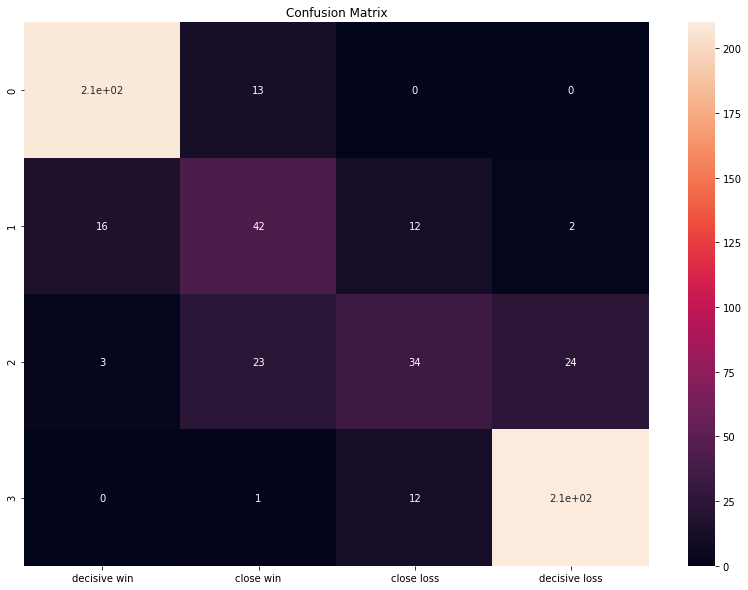

In [74]:
# Classification
y = df.winrate
y = y.apply(classify_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

C = [0.001, 0.01, 0.1, 1, 10]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10]
k = 5
accuracy = k_fold_validation(X_trz, y_tr.values.tolist(), C, gamma, k, model_type='classification')
C, gamma = max(accuracy, key=accuracy.get)

svm = SVC(C=C, gamma=gamma)
svm.fit(X_trz, y_tr)
test_acc = svm.score(X_tez, y_te)
y_pred = svm.predict(X_tez)


print(f'(C: {C}, gamma: {gamma}) yields the highest training accuracy of {accuracy[(C, gamma)] * 100}%')
print(f'Final testing accuracy: {test_acc * 100}%')
print(f'\n{classification_report(y_te, y_pred, target_names=class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
plt.title("Confusion Matrix")
sn.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)